# Train a JointVAE model

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import numpy as np
import torch

use_cuda = torch.cuda.is_available()
use_cuda

True

In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # change to your device

#### Prepare data list

#### Create list of image paths

In [6]:
#loadable_dresses = list(np.loadtxt('data/loadable_women_primary_dress.csv',delimiter=',',skiprows=1,dtype='str'))

In [7]:
#print(len(loadable_dresses))

In [8]:
#loadable_dresses[:5]

In [9]:
!ls /workspace/mnt/crucial_2TB/111_Extra_Data/Macys/

all_wearables20180810  imgs260_3150	      xtrain3150_260260.csv
imgs224_1000	       rayimages2_cleaned.h5  xtrainonly1000.csv


In [10]:
dir_name = '/workspace/mnt/crucial_2TB/111_Extra_Data/Macys/imgs260_3150/'
files = [dir_name + x for x in os.listdir(dir_name)]
files[:3]

['/workspace/mnt/crucial_2TB/111_Extra_Data/Macys/imgs260_3150/img_2658.png',
 '/workspace/mnt/crucial_2TB/111_Extra_Data/Macys/imgs260_3150/img_986.png',
 '/workspace/mnt/crucial_2TB/111_Extra_Data/Macys/imgs260_3150/img_693.png']

#### Split into train and test set

In [11]:
#image_paths_train = loadable_dresses[:88800]
#image_paths_test = loadable_dresses[88800:-124]
image_paths_train = files[:2800]
image_paths_test = files[2800:-1]


print(f"Number of train image paths: {len(image_paths_train):,d}")
print(f"Number of test image paths: {len(image_paths_test):,d}")
print()
print("Sample paths:")
print(image_paths_train[0])
print(image_paths_train[-1])
print(image_paths_test[0])
print(image_paths_test[-1])

Number of train image paths: 2,800
Number of test image paths: 350

Sample paths:
/workspace/mnt/crucial_2TB/111_Extra_Data/Macys/imgs260_3150/img_2658.png
/workspace/mnt/crucial_2TB/111_Extra_Data/Macys/imgs260_3150/img_131.png
/workspace/mnt/crucial_2TB/111_Extra_Data/Macys/imgs260_3150/img_2921.png
/workspace/mnt/crucial_2TB/111_Extra_Data/Macys/imgs260_3150/img_2446.png


In [200]:
from torchvision import transforms
#from utils.dataloaders_custom import get_imagelist_dataloader, ImageListDataset
from utils.dataloader_tools import get_imagelist_dataloader, ImageListDataset, ImgDsetCut5from256

BATCH_SIZE = 50

composed = transforms.Compose([transforms.CenterCrop((256,256)),transforms.Resize((256,256)),transforms.ToTensor()])

# convert rgb is for the cv2 loaded images that I've got in this dir
conv_rgb = True

train_dataset = ImgDsetCut5from256(image_paths_train,transform=composed, 
                                 convert_rgb=conv_rgb, error_handling=False)

test_dataset = ImgDsetCut5from256(image_paths_test, 
                                transform=composed, convert_rgb=conv_rgb, error_handling=False)

train_loader = get_imagelist_dataloader(batch_size=BATCH_SIZE, dataset_object=train_dataset)
test_loader = get_imagelist_dataloader(batch_size=BATCH_SIZE, dataset_object=test_dataset)

In [202]:
#next(iter(train_loader))

### Define latent distribution of the model

In [203]:
# Latent distribution will be joint distribution of 10 gaussian normal distributions
# and one 10 dimensional Gumbel Softmax distribution
latent_spec = {'cont': 10,
               'disc': [10]}

### Build a model

In [269]:
from jointvae.models_256_branching1 import VAE

#model = VAE(latent_spec=latent_spec, hidden_dim=512, img_size=(3, 256, 256), use_cuda=use_cuda)
model = VAE(latent_spec=latent_spec, img_size=(3, 256, 256), use_cuda=use_cuda)

In [270]:
#print(model)

### Train the model

In [271]:
from torch import optim

# Build optimizer
optimizer = optim.Adam(model.parameters(), lr=9e-5, amsgrad=True) # added amsgrad # orig lr 5e-4

In [272]:
from jointvae.training_v1 import Trainer
#from jointvae.training_debug import Trainer

# Define the capacities
# Continuous channels
cont_capacity = [0.0, 5.2, 30000, 30.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0
# Discrete channels
disc_capacity = [0.0, 5.2, 30000, 30.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0

# Build a trainer
trainer = Trainer(model, optimizer,
                  cont_capacity=cont_capacity,
                  disc_capacity=disc_capacity,
                 use_cuda=use_cuda)

#### Initialize visualizer

In [273]:
#from viz.visualize import Visualizer
from viz.visualize_branch1 import Visualizer

viz = Visualizer(model)
viz.save_images = False # needed to add this so it returns a tensor

In [ ]:
# Train model for 10 epochs
# Note this should really be a 100 epochs and trained on a GPU, but this is just to demo

trainer.train(train_loader, epochs=2, save_training_gif=None)

x:  tensor([[[[0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          ...,
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922]],

         [[0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          ...,
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412]],

         [[0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
          [0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
          [0.5137, 0.5137, 0.5137,  ..

x:  tensor([[[[0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          ...,
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922]],

         [[0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          ...,
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412]],

         [[0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
          [0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
          [0.5137, 0.5137, 0.5137,  ..

x:  tensor([[[[0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          ...,
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922]],

         [[0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          ...,
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412]],

         [[0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
          [0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
          [0.5137, 0.5137, 0.5137,  ..

x:  tensor([[[[0.5922, 0.5922, 0.5922,  ..., 0.5529, 0.5529, 0.5529],
          [0.5922, 0.5922, 0.5922,  ..., 0.5529, 0.5529, 0.5529],
          [0.5922, 0.5922, 0.5922,  ..., 0.5529, 0.5529, 0.5529],
          ...,
          [0.5922, 0.5922, 0.5922,  ..., 0.5529, 0.5529, 0.5529],
          [0.5922, 0.5922, 0.5922,  ..., 0.5529, 0.5529, 0.5529],
          [0.5922, 0.5922, 0.5922,  ..., 0.5529, 0.5529, 0.5529]],

         [[0.5412, 0.5412, 0.5412,  ..., 0.5020, 0.5020, 0.5020],
          [0.5412, 0.5412, 0.5412,  ..., 0.5020, 0.5020, 0.5020],
          [0.5412, 0.5412, 0.5412,  ..., 0.5020, 0.5020, 0.5020],
          ...,
          [0.5412, 0.5412, 0.5412,  ..., 0.5020, 0.5020, 0.5020],
          [0.5412, 0.5412, 0.5412,  ..., 0.5020, 0.5020, 0.5020],
          [0.5412, 0.5412, 0.5412,  ..., 0.5020, 0.5020, 0.5020]],

         [[0.5137, 0.5137, 0.5137,  ..., 0.4745, 0.4745, 0.4745],
          [0.5137, 0.5137, 0.5137,  ..., 0.4745, 0.4745, 0.4745],
          [0.5137, 0.5137, 0.5137,  ..

x:  tensor([[[[0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          ...,
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922]],

         [[0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          ...,
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412]],

         [[0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
          [0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
          [0.5137, 0.5137, 0.5137,  ..

x:  tensor([[[[0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          ...,
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922]],

         [[0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          ...,
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412]],

         [[0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
          [0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
          [0.5137, 0.5137, 0.5137,  ..

x:  tensor([[[[0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          ...,
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922]],

         [[0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          ...,
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412]],

         [[0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
          [0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
          [0.5137, 0.5137, 0.5137,  ..

x:  tensor([[[[0.5922, 0.5922, 0.5922,  ..., 0.5529, 0.5529, 0.5529],
          [0.5922, 0.5922, 0.5922,  ..., 0.5529, 0.5529, 0.5529],
          [0.5922, 0.5922, 0.5922,  ..., 0.5529, 0.5529, 0.5529],
          ...,
          [0.5922, 0.5922, 0.5922,  ..., 0.5098, 0.5059, 0.5059],
          [0.5922, 0.5922, 0.5922,  ..., 0.5098, 0.5059, 0.5059],
          [0.5922, 0.5922, 0.5922,  ..., 0.5098, 0.5059, 0.5059]],

         [[0.5412, 0.5412, 0.5412,  ..., 0.5020, 0.5020, 0.5020],
          [0.5412, 0.5412, 0.5412,  ..., 0.5020, 0.5020, 0.5020],
          [0.5412, 0.5412, 0.5412,  ..., 0.5020, 0.5020, 0.5020],
          ...,
          [0.5412, 0.5412, 0.5412,  ..., 0.4627, 0.4588, 0.4588],
          [0.5412, 0.5412, 0.5412,  ..., 0.4627, 0.4588, 0.4588],
          [0.5412, 0.5412, 0.5412,  ..., 0.4627, 0.4588, 0.4588]],

         [[0.5137, 0.5137, 0.5137,  ..., 0.4824, 0.4824, 0.4824],
          [0.5137, 0.5137, 0.5137,  ..., 0.4824, 0.4824, 0.4824],
          [0.5137, 0.5137, 0.5137,  ..

x:  tensor([[[[0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          ...,
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922]],

         [[0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          ...,
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412]],

         [[0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
          [0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
          [0.5137, 0.5137, 0.5137,  ..

x:  tensor([[[[0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          ...,
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922]],

         [[0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          ...,
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412]],

         [[0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
          [0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
          [0.5137, 0.5137, 0.5137,  ..

x:  tensor([[[[0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          ...,
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922]],

         [[0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          ...,
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412]],

         [[0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
          [0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
          [0.5137, 0.5137, 0.5137,  ..

x:  tensor([[[[0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          ...,
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922]],

         [[0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          ...,
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412]],

         [[0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
          [0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
          [0.5137, 0.5137, 0.5137,  ..

x:  tensor([[[[0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          ...,
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922]],

         [[0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          ...,
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412]],

         [[0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
          [0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
          [0.5137, 0.5137, 0.5137,  ..

x:  tensor([[[[0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          ...,
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922]],

         [[0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          ...,
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412]],

         [[0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
          [0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
          [0.5137, 0.5137, 0.5137,  ..

x:  tensor([[[[0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          ...,
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922]],

         [[0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          ...,
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412]],

         [[0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
          [0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
          [0.5137, 0.5137, 0.5137,  ..

x:  tensor([[[[0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          ...,
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
          [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922]],

         [[0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          ...,
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412],
          [0.5412, 0.5412, 0.5412,  ..., 0.5412, 0.5412, 0.5412]],

         [[0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
          [0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
          [0.5137, 0.5137, 0.5137,  ..

In [ ]:
print('hi')

In [ ]:
save_image_path = "sample_images/home/256/"
model_name = "banch_test1"

In [ ]:
# Get a batch of data
for batch, labels in test_loader:
    break

In [ ]:
batch[0].shape

### Visualize

In [ ]:
# Plot reconstructions
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Get a batch of data
for batch, labels in test_loader:
    break

# Reconstruct data using Joint-VAE model
recon = viz.reconstructions(batch)

plt.figure(figsize=(26,26))
plt.imshow(np.rot90(np.transpose(recon.numpy(),(2,1,0)),k=3));
plt.savefig(save_image_path + model_name + "_reconstructions.png",dpi=200)

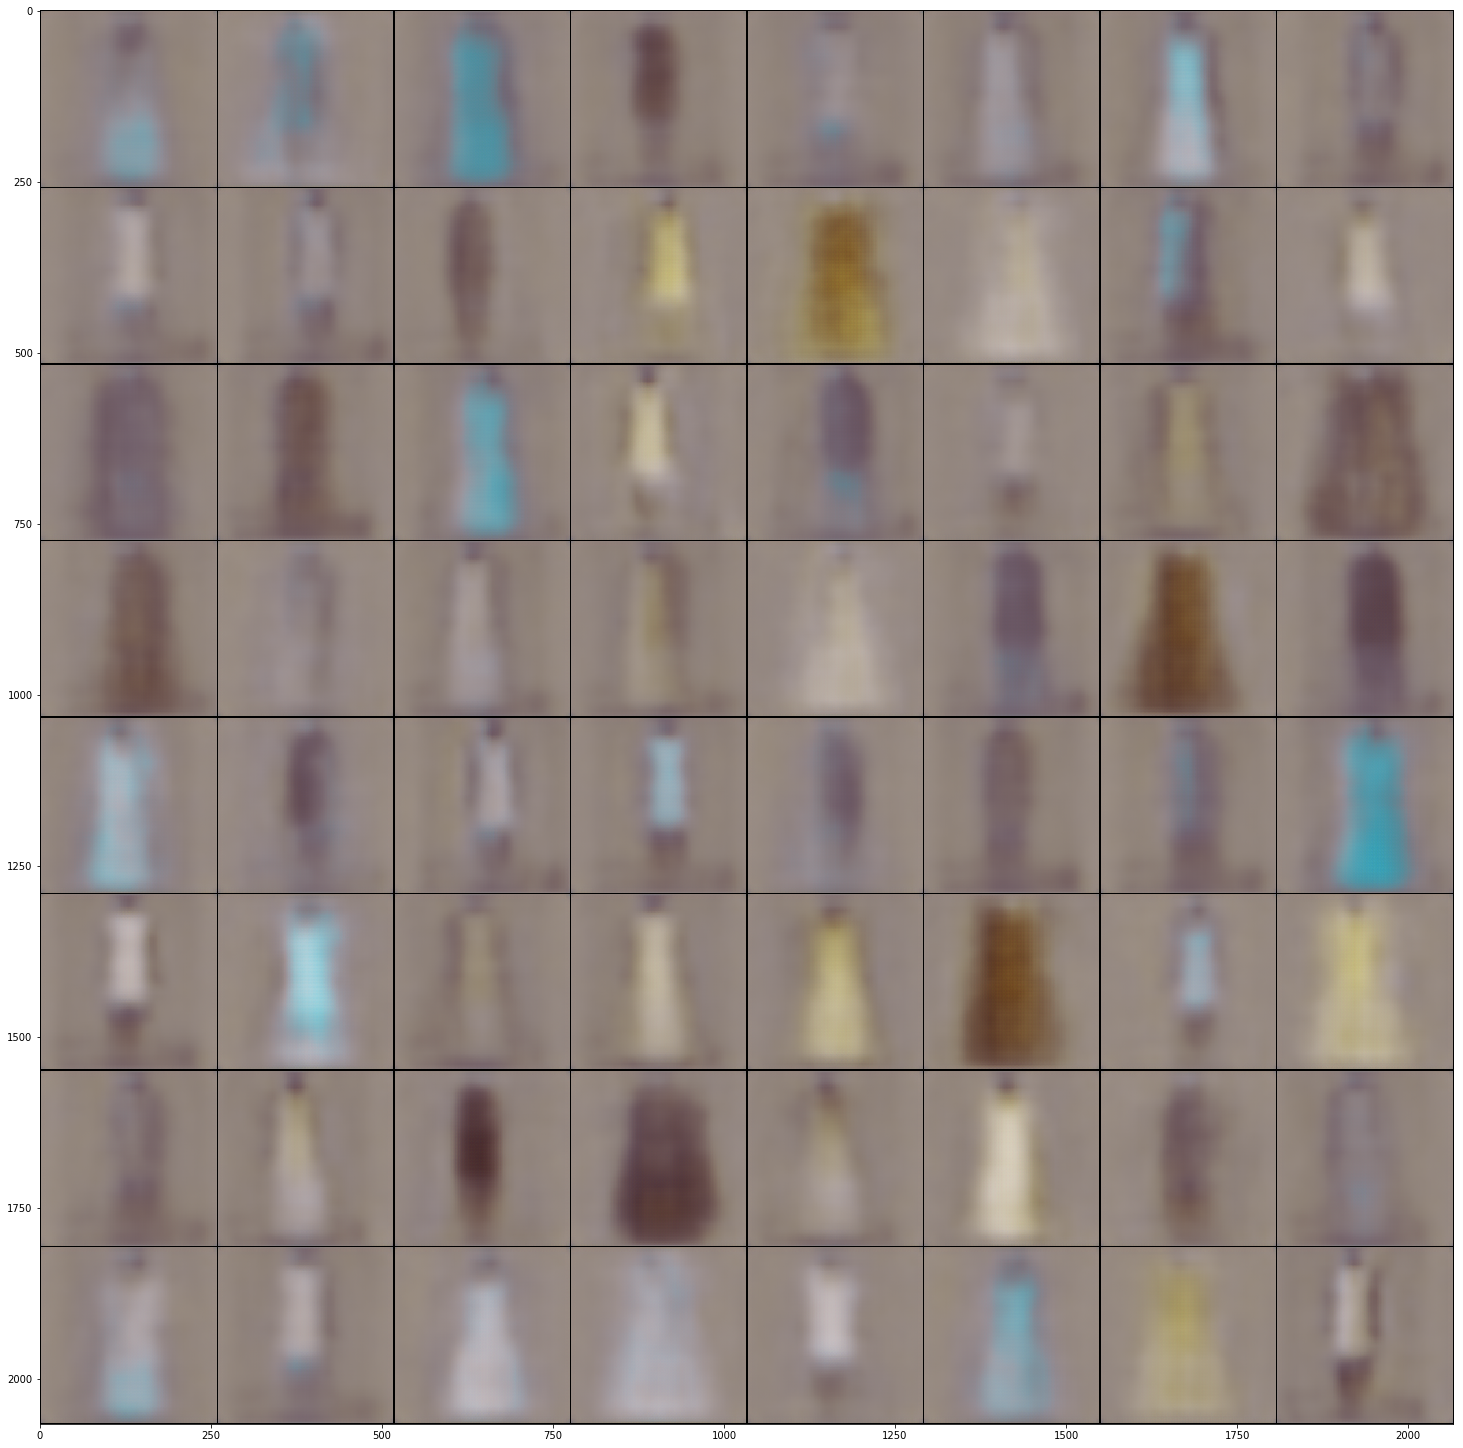

In [40]:
# Plot samples
samples = viz.samples()

plt.figure(figsize=(26,26))
plt.imshow(np.rot90(np.transpose(samples.numpy(),(2,1,0)),k=3));
plt.savefig(save_image_path + model_name + "_samples.png",dpi=200)

#### Traverses all latent dimensions one by one and plots a grid of images where each row corresponds to a latent traversal of one latent dimension

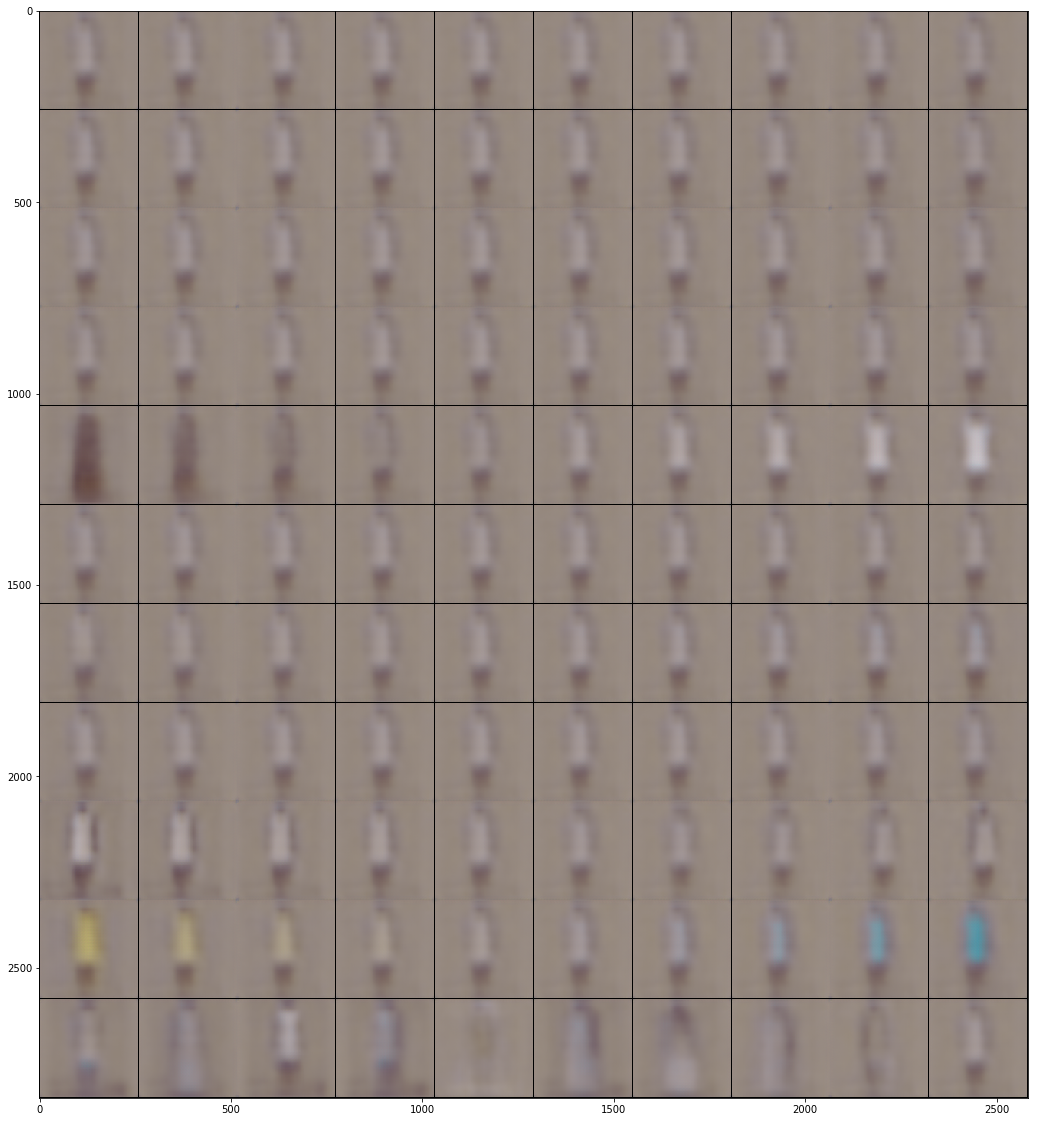

In [41]:
# Plot all traversals
traversals = viz.all_latent_traversals(size=10)

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig(save_image_path + model_name + "_all_traversals_n20.png",dpi=200)

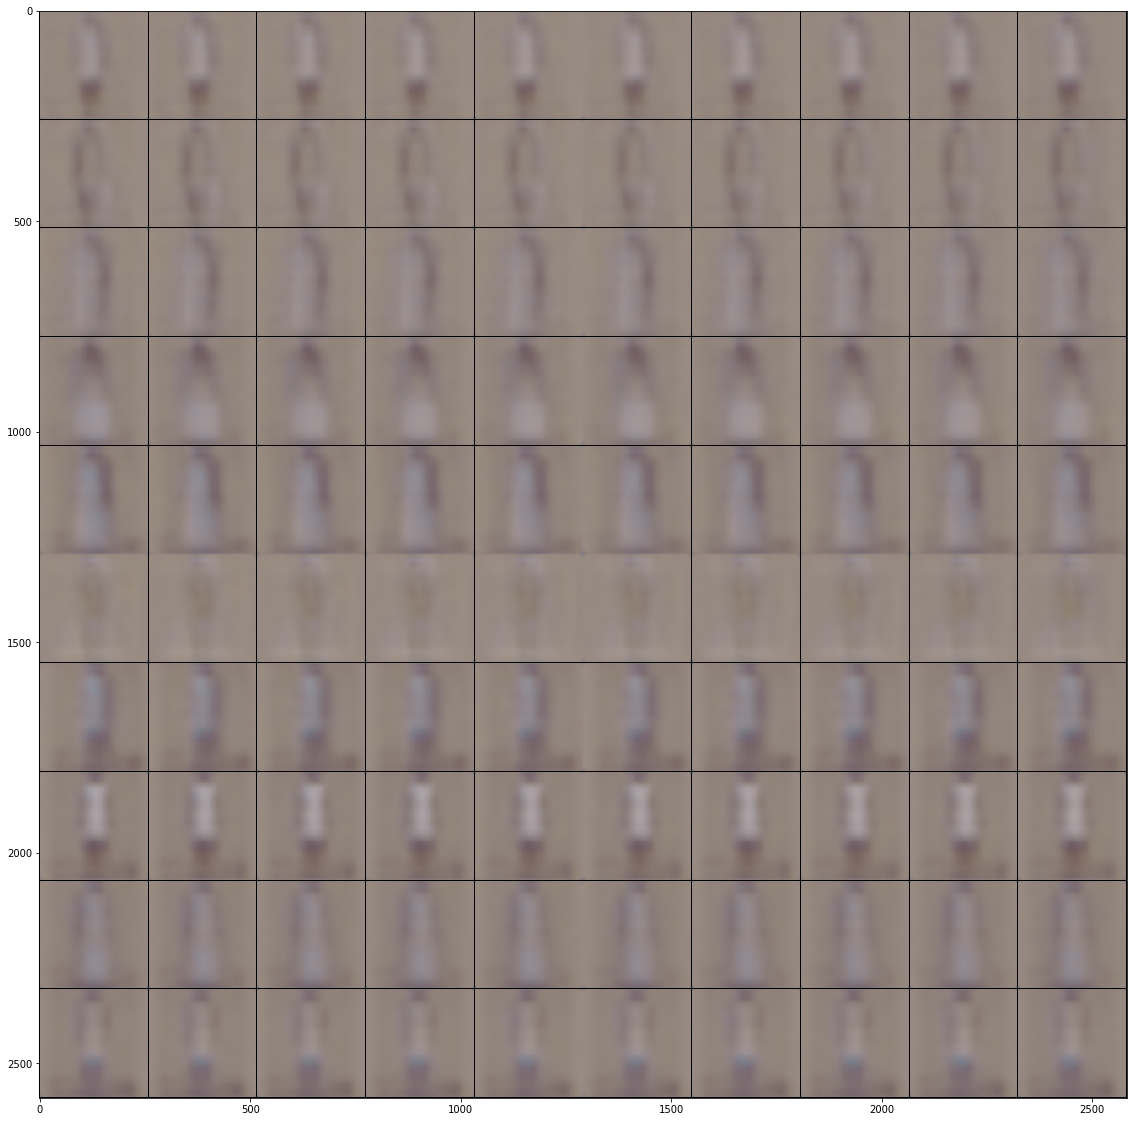

In [42]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=2, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig(save_image_path + model_name + "_traversals2100.png",dpi=200)

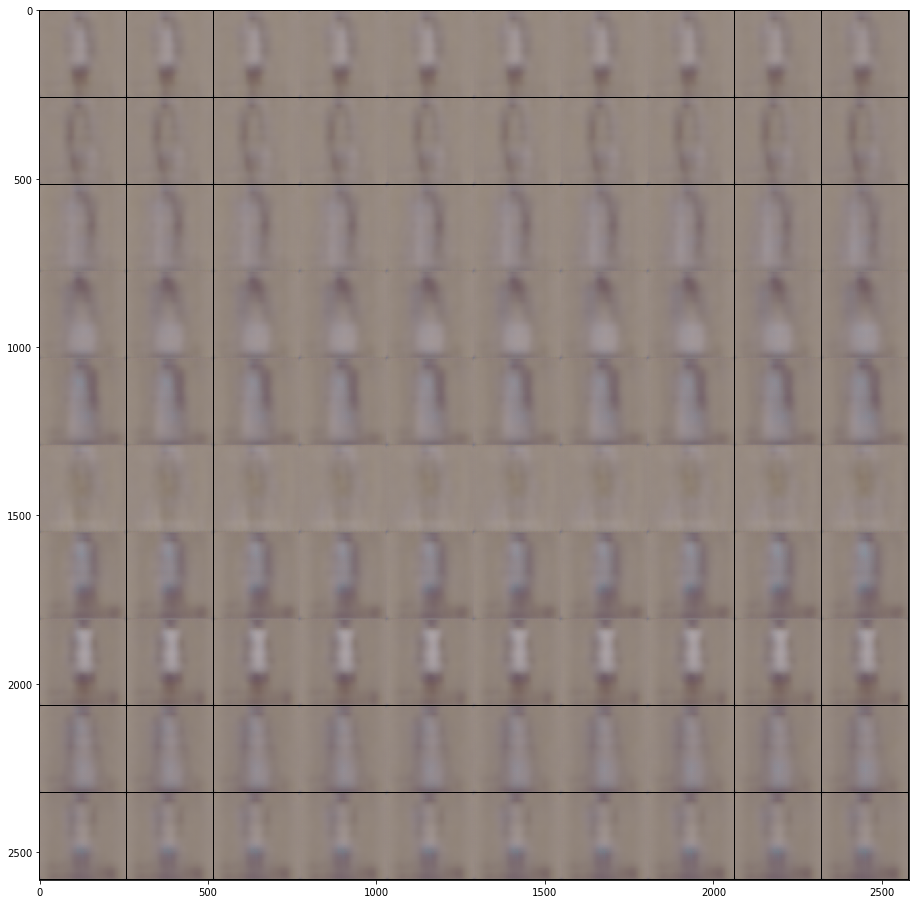

In [43]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=1, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(16,16))
plt.imshow(traversals.numpy()[0, :, :]);
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig(save_image_path + model_name + "_traversals1100.png",dpi=200)

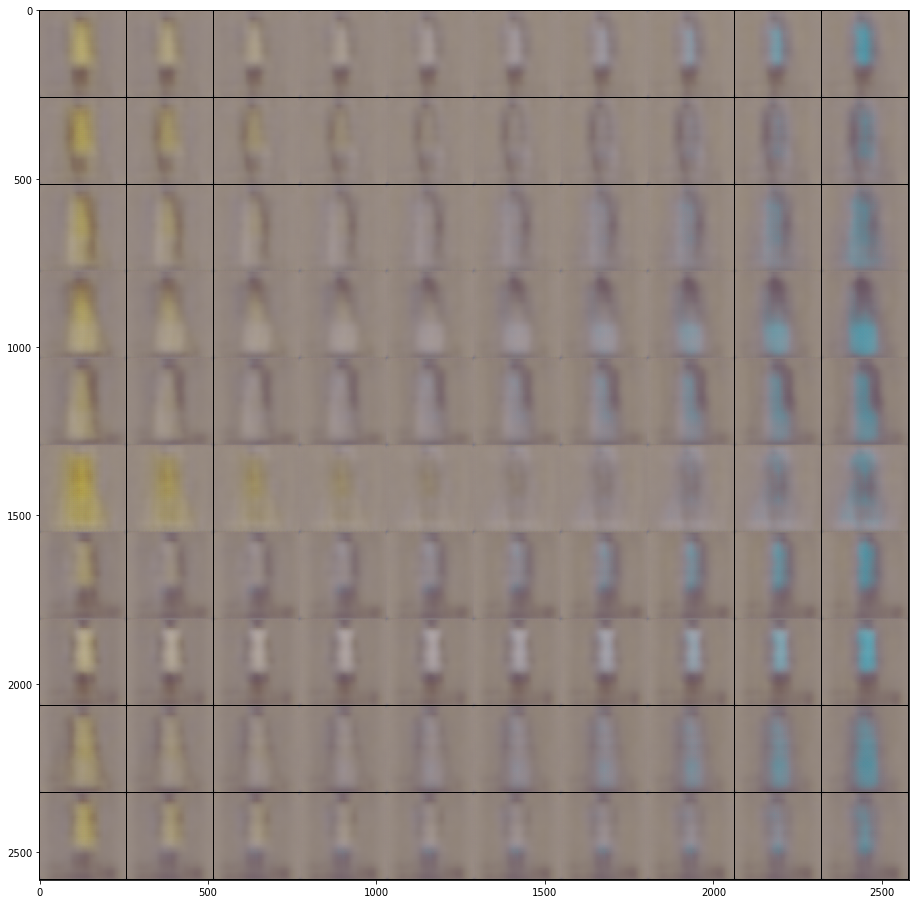

In [44]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=9, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(16,16))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig(save_image_path + model_name + "_traversals9100.png",dpi=200)

In [45]:
!ls

README.md
RandomUtilsandTests.ipynb
__pycache__
all_traversals.png
data
dataloading_pytorch_test.ipynb
imgs
jointvae
latent_traversals.py
load_model.ipynb
main.py
model_size_debug.txt
requirements.txt
sample_images
train_305_256_cj1_gpu0-Copy1.ipynb
train_305_256_cj1_gpu0.ipynb
train_305_256_xint_gpu0-Copy1.ipynb
train_305_256_xint_gpu0.ipynb
train_305_256_xint_gpu1_3opdata.ipynb
train_306_128_xint_cp0.ipynb
train_306_128_xint_cp1.ipynb
train_306_256_convjump1_gpu0.ipynb
train_306_256_convjump1_gpu1.ipynb
train_home_128_xint_test1.ipynb
train_home_256_branching1_3150data_gpu1.ipynb
train_home_256_cj2bn_3150data_gpu1.ipynb
train_home_256_xint_3150data_cp0-Copy2.ipynb
train_home_256_xint_3150data_cp0.ipynb
train_home_256_xint_3150data_cp1.ipynb
train_home_64_xint_croptop_cp1.ipynb
train_model.ipynb
train_model_loadable_64_croptotop.ipynb
train_model_loadable_64_xstyle_int_croptotop.ipynb
train_model_realdata_305_64.ipynb
train_model_realdata_306_260_v1.ipynb
train_nb_load_64_xstyleint_cr

### Save Model

In [46]:
torch.save(model.state_dict(),"trained_models" + "statedict_" + model_name + ".pth") # save state dict
#torch.save(model, model_name) # save full model

In [47]:
print("Done training: ",model_name)

Done training:  cj2bn_hd512_e200_b50_30k5_2_c10d10_gam30


#### Restore Model from State Dict

In [ ]:
sd_model = VAE(latent_spec=latent_spec, img_size=(3, 64, 64))
sd_model.load_state_dict(torch.load("statedict_" + model_name))

#### Restore Full Model
* Note in this case the serialized data is bound to the specific classes and exact directory strucutre used.

In [ ]:
full_model = torch.load(model_name)

In [ ]:
type(full_model)

In [ ]:
type(sd_model)

In [ ]:
!ls